In [6]:
import sys
from pathlib import Path

# Setup import system
project_root = Path.cwd().parents[3]
sys.path.append(str(project_root))

In [7]:
import numpy as np
import pandas as pd

from src.homeworks.KNN.knn_classifier.KNNClassifier import KNNClassifier
from src.homeworks.KNN.processing.data_split import train_test_split
from src.homeworks.KNN.processing.scaling_strategies.min_max_scaler import MinMaxScaler 
from src.homeworks.KNN.processing.scaling_strategies.max_abs_scaler import MaxAbsScaler 
from src.homeworks.KNN.processing.scaling_strategies.standard_scaler import StandardScaler
from src.homeworks.KNN.processing.metrics import accuracy, f1_score
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv("cancer.csv")

In [9]:
df.head(5)

,label,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [10]:
# M -> 0; B -> 1
df["label"] = pd.factorize(df["label"])[0]
df["label"].value_counts()

label
1    357
0    212
Name: count, dtype: int64

In [11]:
df[df.isna().any(axis=1)]
# No Nan in table

,label,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30


In [12]:
X = df.drop(columns='label')
y = df['label']
tuple_x = [tuple(point) for point in X.values.tolist()]
X_train, X_test, y_train, y_test = train_test_split(tuple_x, y.tolist(), to_shuffle=True)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, to_shuffle=True)

In [13]:
# SCALING DATA

min_max = MinMaxScaler()
X_train_min_max = min_max.fit_transform(X_train)
X_validation_min_max = min_max.fit_transform(X_validation)
X_test_min_max = min_max.fit_transform(X_test)

max_abs = MaxAbsScaler()
X_train_max_abs = max_abs.fit_transform(X_train)
X_validation_max_abs = max_abs.fit_transform(X_validation)
X_test_max_abs = max_abs.fit_transform(X_test)

standart = StandardScaler()
X_train_standart = standart.fit_transform(X_train)
X_validation_standart = standart.fit_transform(X_validation)
X_test_standart = standart.fit_transform(X_test)

In [14]:
# Testing values for k, leaf_size

k_values = range(1, 100, 5)
leaf_sizes = range(5, 100, 5)

In [15]:
# Choosing best hyperparameters by metric

def best_hyperparameters(matrix, metric_name, leaf_sizes, k_values, to_save=True, to_show=True) -> tuple[int, int, float]:
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, interpolation='nearest', cmap='viridis')
    plt.colorbar(label='Accuracy')
    plt.xticks(ticks=np.arange(len(k_values)), labels=k_values)
    plt.yticks(ticks=np.arange(len(leaf_sizes)), labels=leaf_sizes)
    plt.xlabel("Number of neighbors (k)")
    plt.ylabel("leaf_size")
    plt.title(f"{metric_name} depending on k and leaf_size")
    if to_save:
        plt.savefig(f"{metric_name}.png")
    if to_show:
        plt.show()
    best_index = np.unravel_index(np.argmax(matrix), matrix.shape)
    best_leaf_size = leaf_sizes[best_index[0]]
    best_k = k_values[best_index[1]]
    return best_leaf_size, best_k, matrix[best_index]

In [16]:
# Compute accuracy and f1 

def get_accuracy_f1_matrix(X_train, X_validation, y_train, y_validation, leaf_sizes, k_values):
    accuracy_matrix = np.zeros((len(leaf_sizes), len(k_values)))
    f1_matrix = np.zeros((len(leaf_sizes), len(k_values)))
    for i, leaf_size in enumerate(leaf_sizes):
        for j, k in enumerate(k_values):
            model = KNNClassifier(k, leaf_size)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_validation)
            accuracy_matrix[i, j] = accuracy(y_validation, y_pred)
            f1_matrix[i, j] = f1_score(y_validation, y_pred)
    return accuracy_matrix, f1_matrix

<div align="center"><b>Without scaling</b></div>


In [17]:
# Compute accuracy and f1

X_t = X_train
X_v = X_validation
y_t = y_train
y_v = y_validation

accuracy_matrix_no_scale, f1_matrix_no_scale = get_accuracy_f1_matrix(X_t, X_v, y_t, y_v, leaf_sizes, k_values)
print("completed")

completed


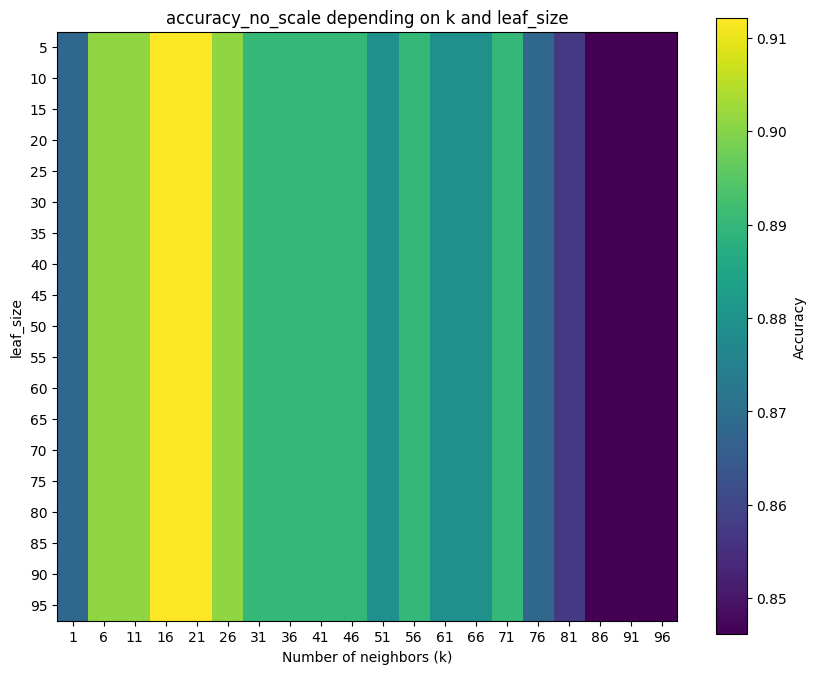

best leaf_size=5, k=16, accuracy=0.912


In [18]:
accur_leaf_size, accur_k, accur = best_hyperparameters(accuracy_matrix_no_scale, "accuracy_no_scale", leaf_sizes, k_values)
print(f"best leaf_size={accur_leaf_size}, k={accur_k}, accuracy={accur:.3f}")

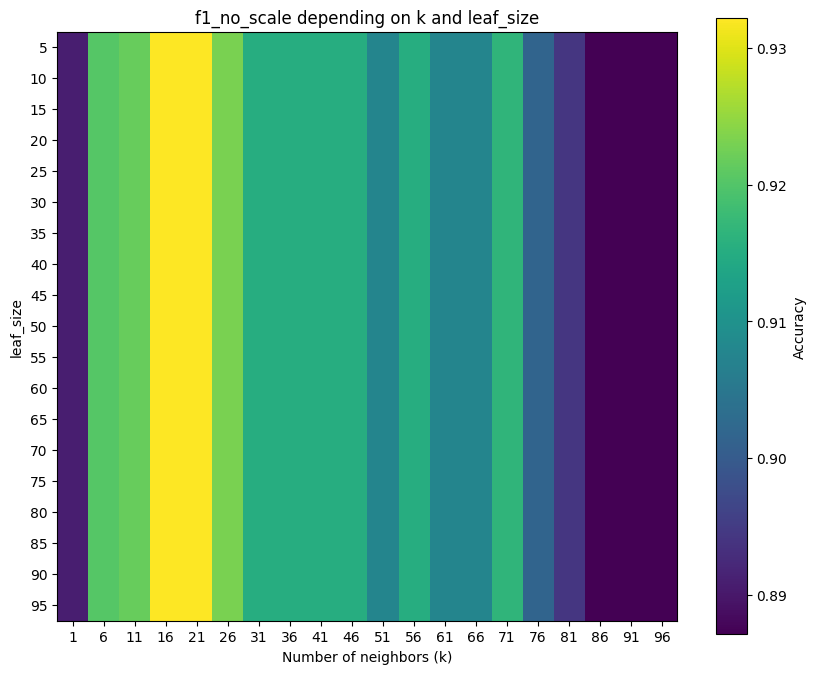

best leaf_size=5, k=16, f1_score=0.932


In [19]:
f1_leaf_size, f1_k, f1 = best_hyperparameters(f1_matrix_no_scale, "f1_no_scale", leaf_sizes, k_values)
print(f"best leaf_size={f1_leaf_size}, k={f1_k}, f1_score={f1:.3f}")

The result is almost independent of leaf_size. The best result for both metrics **k=16, leaf_size=5**

**(accuracy 0.923, f1_score 0.938)**

<div align="center"><b>MinMaxScaling</b></div>

In [20]:
# Compute accuracy and f1 

X_t = X_train_min_max
X_v = X_validation_min_max
y_t = y_train
y_v = y_validation

accuracy_matrix_min_max, f1_matrix_min_max = get_accuracy_f1_matrix(X_t, X_v, y_t, y_v, leaf_sizes, k_values)
print("completed")

completed


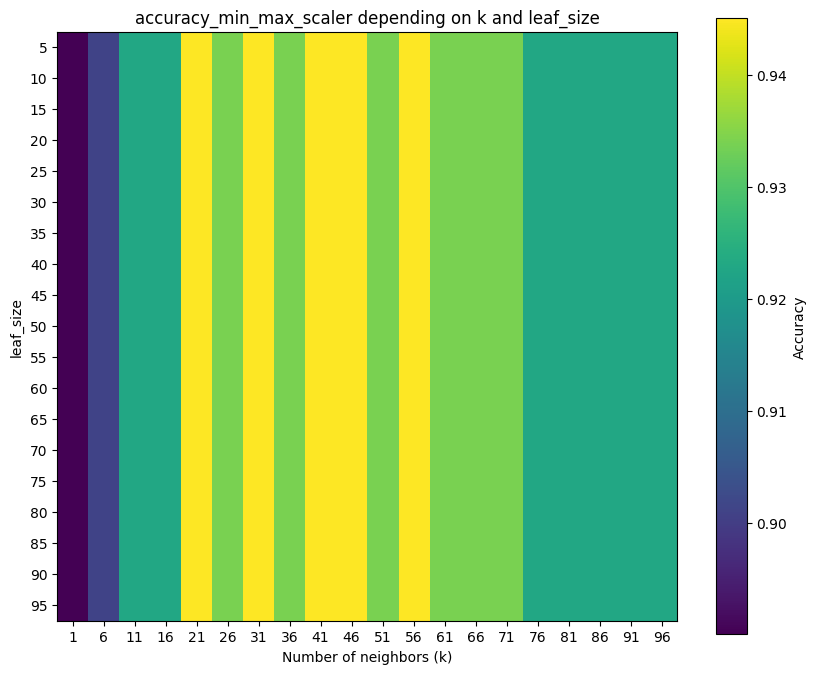

best leaf_size=5, k=21, accuracy=0.945


In [21]:
accur_leaf_size, accur_k, accur = best_hyperparameters(accuracy_matrix_min_max, "accuracy_min_max_scaler", leaf_sizes, k_values)
print(f"best leaf_size={accur_leaf_size}, k={accur_k}, accuracy={accur:.3f}")

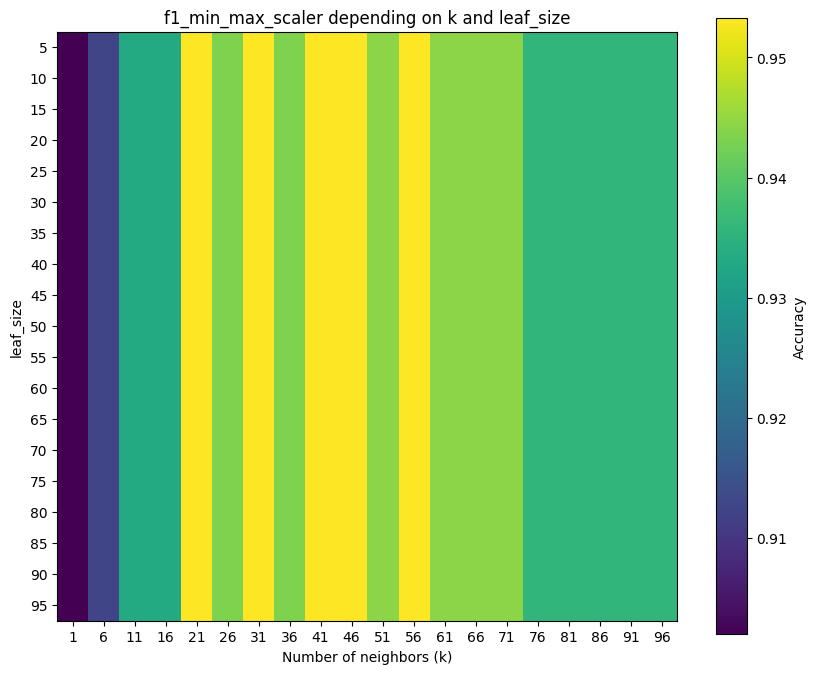

best leaf_size=5, k=21, f1_score=0.953


In [22]:
f1_leaf_size, f1_k, f1 = best_hyperparameters(f1_matrix_min_max, "f1_min_max_scaler", leaf_sizes, k_values)
print(f"best leaf_size={f1_leaf_size}, k={f1_k}, f1_score={f1:.3f}")

The result is almost independent of leaf_size. The best result for both metrics **k=21, leaf_size=5**.

**(accuracy 0.967, f1_score 0.972)**

<div align="center"><b>MaxAbsScaling</b></div>

In [23]:
# Compute accuracy and f1 

X_t = X_train_max_abs
X_v = X_validation_max_abs
y_t = y_train
y_v = y_validation

accuracy_matrix_max_abs, f1_matrix_max_abs = get_accuracy_f1_matrix(X_t, X_v, y_t, y_v, leaf_sizes, k_values)
print("completed")

completed


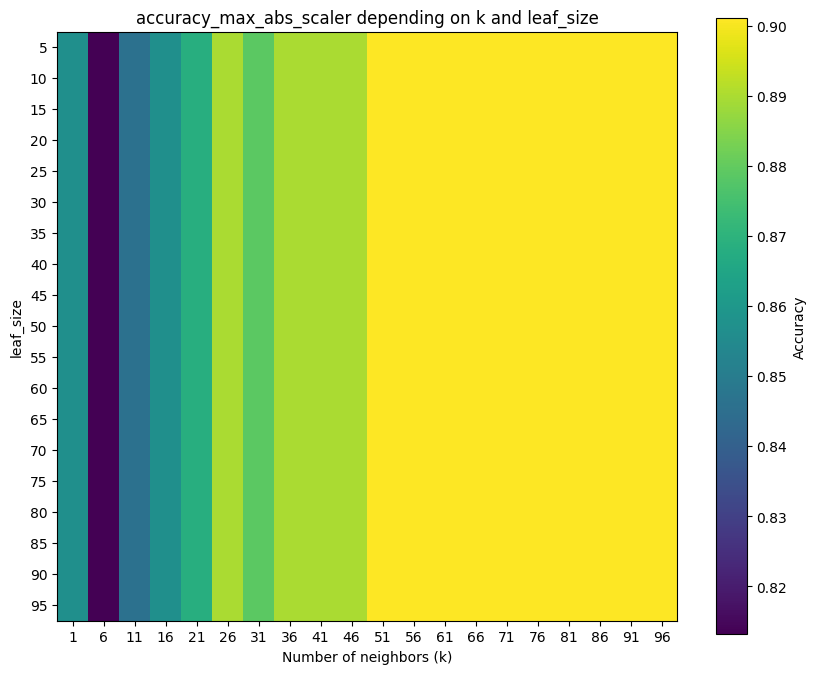

best leaf_size=5, k=51, accuracy=0.901


In [24]:
accur_leaf_size, accur_k, accur = best_hyperparameters(accuracy_matrix_max_abs, "accuracy_max_abs_scaler", leaf_sizes, k_values)
print(f"best leaf_size={accur_leaf_size}, k={accur_k}, accuracy={accur:.3f}")

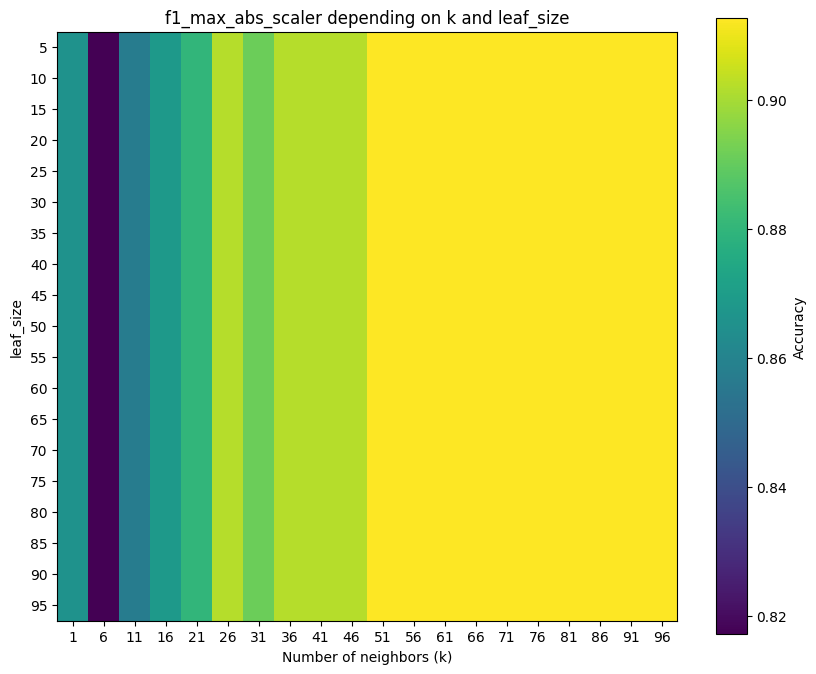

best leaf_size=5, k=51, f1_score=0.913


In [25]:
f1_leaf_size, f1_k, f1 = best_hyperparameters(f1_matrix_max_abs, "f1_max_abs_scaler", leaf_sizes, k_values)
print(f"best leaf_size={f1_leaf_size}, k={f1_k}, f1_score={f1:.3f}")

The result is almost independent of leaf_size. The best result for both metrics **k=51, leaf_size=5**.

**(accuracy 0.879, f1_score 0.891)**

<div align="center"><b>StandardScaler</b></div>

In [26]:
# Compute accuracy and f1 

X_t = X_train_standart
X_v = X_validation_standart
y_t = y_train
y_v = y_validation

accuracy_matrix_standart, f1_matrix_standart = get_accuracy_f1_matrix(X_t, X_v, y_t, y_v, leaf_sizes, k_values)
print("completed")

completed


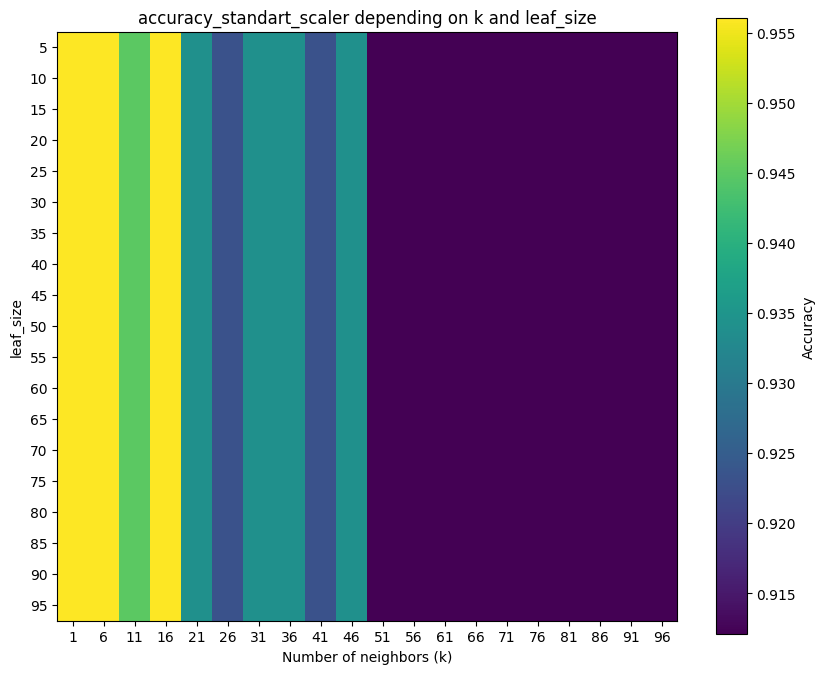

best leaf_size=5, k=1, accuracy=0.956


In [27]:
accur_leaf_size, accur_k, accur = best_hyperparameters(accuracy_matrix_standart, "accuracy_standart_scaler", leaf_sizes, k_values)
print(f"best leaf_size={accur_leaf_size}, k={accur_k}, accuracy={accur:.3f}")

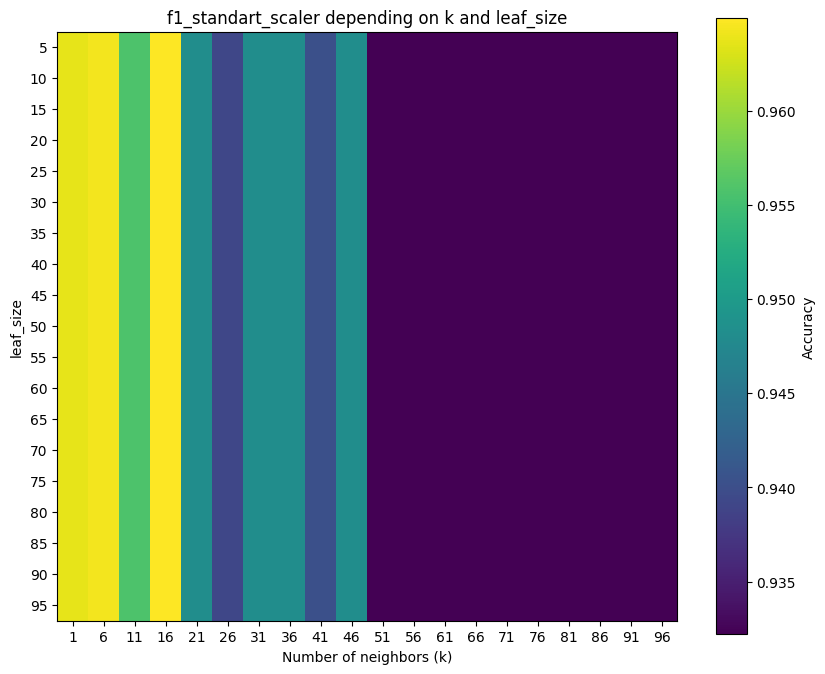

best leaf_size=5, k=16, f1_score=0.965


In [28]:
f1_leaf_size, f1_k, f1 = best_hyperparameters(f1_matrix_standart, "f1_standart_scaler", leaf_sizes, k_values)
print(f"best leaf_size={f1_leaf_size}, k={f1_k}, f1_score={f1:.3f}")

The result is almost independent of leaf_size. The best result for both metrics **k=16, leaf_size=5**.

**(accuracy 0.978, f1_score 0.982)**

<div align="center"><b>Run test</b></div>

In [36]:
knn_no_scale = KNNClassifier(k=16, leaf_size=5)
knn_no_scale.fit(X_train, y_train)
result_no_scale = knn_no_scale.predict(X_test)

In [37]:
knn_min_max = KNNClassifier(k=21, leaf_size=5)
knn_min_max.fit(X_train_min_max, y_train)
result_min_max = knn_min_max.predict(X_test_min_max)

In [38]:
knn_max_abs = KNNClassifier(k=51, leaf_size=5)
knn_max_abs.fit(X_train_max_abs, y_train)
result_max_abs = knn_max_abs.predict(X_test_max_abs)

In [39]:
knn_standart = KNNClassifier(k=16, leaf_size=5)
knn_standart.fit(X_train_standart, y_train)
result_standart = knn_standart.predict(X_test_standart)

In [42]:
accuracy_no_scale = accuracy(result_no_scale, y_test)
accuracy_min_max = accuracy(result_min_max, y_test)
accuracy_max_abs = accuracy(result_max_abs, y_test)
accuracy_standart = accuracy(result_standart, y_test)

f1_no_scale = f1_score(result_no_scale, y_test)
f1_min_max = f1_score(result_min_max, y_test)
f1_max_abs = f1_score(result_max_abs, y_test)
f1_standart = f1_score(result_standart, y_test)

print(f"""NoScale Accuracy={accuracy_no_scale:.3f}, f1_score={f1_no_scale:.3f}
MinMax Accuracy={accuracy_min_max:.3f}, f1_score={f1_min_max:.3f}
MaxAbs Accuracy={accuracy_max_abs:.3f}, f1_score={f1_max_abs:.3f}
StandartScale Accuracy={accuracy_standart:.3f}, f1_score={f1_standart:.3f}""")

NoScale Accuracy=0.912, f1_score=0.935
MinMax Accuracy=0.895, f1_score=0.915
MaxAbs Accuracy=0.842, f1_score=0.868
StandartScale Accuracy=0.974, f1_score=0.980


**StandartScale, k=6, leaf_size=5**

Accuracy = 0.974, f1 = 0.980